# EDA и RFM-сегментация (e-learning)

Предлагается проанализировать предоставленную информацию** по обучению студентов и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

2. Выявить самый сложный и самый простой экзамен: найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью**.

3. По каждому предмету определить средний срок сдачи экзаменов (под сдачей подразумевается последнее успешное прохождение экзамена студентом).

4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

5. В период с начала 2013 по конец 2014 определить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

6. Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированную кластеризацию расположить следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента добавить границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

** Данные взяты из материалов курса **Karpov Courses** "Аналитик данных" 

** завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

# Данные

Ниже описание необходимых для выполнения проекта файлов с таблицами.

**assessments.csv** — этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

code_module — идентификационный код предмета.

code_presentation — семестр (Идентификационный код).

id_assessment — тест (Идентификационный номер ассессмента).

assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

**courses.csv** — файл содержит список предметов по семестрам.

code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код).

module_presentation_length — продолжительность семестра в днях.

**studentAssessment.csv** — этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

id_assessment — тест (идентификационный номер).

id_student — идентификационный номер студента.

date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

**studentRegistration.csv** — этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код)

id_student — идентификационный номер студента.

date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

# Перед выполнением:

1. Импортируем необходимые для работы библиотеки
2. Внимательнее посмотрим на файлы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
assessments = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/M4W33q4ez06x9A", sep=",")
courses = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/MhciZGz9-a4BZg", sep=",")
studentAssessment = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Mve0QQCHy9LvgQ", sep=",")
studentRegistration = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/7KbZkSjwShgXuA", sep=",")

# assessments

In [3]:
assessments.head(5)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


**Кол-во строк и столбцов**

In [4]:
assessments.shape

(206, 6)

**Типы данных в файле**

In [5]:
assessments.dtypes

code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object

**Наличие пустых значений**

In [6]:
assessments.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

**Пустые значения в столбце date относятся к типу теста - Exam. Можно предположить, что такие экзамены еще не были окончательно сданы**

In [7]:
assessments.query('date.isna()')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


**Какие типы тестов есть**

In [8]:
assessments['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

**Кол-во уникальных тестов. Совпадает с кол-вом строк**

In [9]:
assessments['id_assessment'].nunique()

206

**Посмотрим на взаимосвязть предметов и тестов**

По каждому предмету в кач-ве типа оценки обязательно присутствует экзамен

In [10]:
assessments.groupby(['code_module', 'assessment_type']) \
    .agg({'weight':'sum'})

weight
code_module assessment_type        
AAA         Exam              200.0
            TMA               200.0
BBB         CMA                15.0
            Exam              400.0
            TMA               385.0
CCC         CMA                50.0
            Exam              400.0
            TMA               150.0
DDD         CMA                25.0
            Exam              400.0
            TMA               375.0
EEE         Exam              300.0
            TMA               300.0
FFF         CMA                 0.0
            Exam              400.0
            TMA               400.0
GGG         CMA                 0.0
            Exam              300.0
            TMA                 0.0

Кол-во ассесментов с оценкой в виде экзамена - 24

In [11]:
assessments.groupby(['id_assessment', 'assessment_type'], as_index=False) \
    .agg({'weight':'sum'}).query('assessment_type == "Exam"').id_assessment.nunique()

24

Кол-во ассесментов с оценкой в виде TMA - 106

In [12]:
assessments.groupby(['code_module', 'id_assessment', 'assessment_type', 'code_presentation'], as_index=False) \
    .agg({'weight':'sum'}) \
    .query('assessment_type == "TMA"').id_assessment.nunique()

106

Кол-во ассесментов с оценкой в виде TMA - 76

In [13]:
assessments.groupby(['code_module', 'id_assessment', 'assessment_type', 'code_presentation'], as_index=False) \
    .agg({'weight':'count'}) \
    .query('assessment_type == "CMA"').id_assessment.nunique()

76

# courses

In [14]:
courses.head(5)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


**Кол-во строк и столбцов**

In [15]:
courses.shape

(22, 3)

**Типы данных в файле**

In [16]:
courses.dtypes

code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object

**Наличие пустых значений**

In [17]:
courses.isna().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

**Уникальные предметы**

In [18]:
courses['code_module'].unique()

array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

**Семестры**

In [19]:
courses['code_presentation'].unique()

array(['2013J', '2014J', '2013B', '2014B'], dtype=object)

# studentAssessment

In [20]:
studentAssessment.head(5)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


**Кол-во строк и столбцов**

In [21]:
studentAssessment.shape

(173912, 5)

**Типы данных в файле**

In [22]:
studentAssessment.dtypes

id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object

**Наличие пустых значений**

Пустые значения приходятся на колонку с оценкой (score). Можно предположить, что эти тесты еще просто не были оценены

In [23]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [24]:
studentAssessment.query('score.isnull()')

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


**Кол-во уникальных студентов, которые сдавали какие-либо тесты**

In [25]:
studentAssessment['id_student'].nunique()

23369

# studentRegistration

In [26]:
studentRegistration.head(5)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


**Кол-во строк и столбцов**

In [27]:
studentRegistration.shape

(32593, 5)

**Типы данных в файле**

In [28]:
studentRegistration.dtypes

code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object

**Наличие пустых значений**

In [29]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

**Кол-во уникальных студентов, которые регистрировались на курсы**

In [30]:
studentRegistration['id_student'].nunique()

28785

# 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

По условию оценки в виде экзаменов рассматриваются отдельно и имеют вес 100% (сумма всех остальных оценок составляет 100%). Курсом можем считать предмет в конкретном семестре (code_module). Успешно завершенным курсом будем считать ассесмент с типом оценки - Exam (Экзамен) и с оценкой (score) выше 40 баллов.

**За отправную точку берем файл с информацией о результатах тестов студентов - studentAssessment**

По шагам:
1. Фильтруем данные по успешно сданным тестам - оценка от 40 балов
2. Добавляем к отфильтрованным данным информацию с оценками и типами тестов
3. Удаляем дубликаты
4. Полученную таблицу фильтруем по типу теста - Exam
5. Группируем по студентам
6. Агрегируем по кол-ву курсов (получаем пару : Студент - Кол-во сданных курсов)
7. Оставляем только студентов с одним успешно завершенным курсом

In [31]:
studentAssessment \
    .query('score >= 40') \
    .merge(assessments, how='inner', on='id_assessment')\
    .drop_duplicates() \
    .query('assessment_type == "Exam"') \
    .groupby('id_student') \
    .agg({'code_module':'count'}) \
    .query('code_module == 1').code_module.sum()

3802

**Ответ - 3802 студентов успешно сдали только один курс**

# 2. Выявить самый сложный и самый простой экзамен: найти курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*

**завершаемость** = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

Объединяем таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) 
и отфильтруем по типу теста - Exam

In [32]:
FullstudentAssessment = studentAssessment \
    .merge(assessments, how='inner', on='id_assessment') \
    .drop_duplicates() \
    .query('assessment_type == "Exam"') 

В полученную таблицу добавляем колонку successs_exam с информацией по успешности сдачи теста (>= 40 - зачет, <40 незачет). Приводим тип данных в колонке к числовому

In [33]:
FullstudentAssessment['success_exam'] = FullstudentAssessment['score'] >= 40
FullstudentAssessment['success_exam'] = FullstudentAssessment['success_exam'].astype(int)
FullstudentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,success_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


Группируем таблицу по id теста и рассчитываем кол-во успешных сдач экзамена (sum - суммируем единицы), а также общее кол-во попыток (count)

In [34]:
FullstudentAssessmentSuccess = FullstudentAssessment \
    .groupby(['id_assessment', 'code_module'], as_index=False) \
    .agg({'success_exam': ['sum','count']})

Добавляем колонку с завершаемостью (кол-во успешных экзаменов / кол-во всех попыток сдать экзамен)

In [35]:
FullstudentAssessmentSuccess['success_rate'] = FullstudentAssessmentSuccess.success_exam['sum'] / FullstudentAssessmentSuccess.success_exam['count']
FullstudentAssessmentSuccess.head()

id_assessment code_module success_exam       success_rate
                                     sum count             
0         24290         CCC          664   747     0.888889
1         24299         CCC         1019  1168     0.872432
2         25340         DDD          504   602     0.837209
3         25354         DDD          878   968     0.907025
4         25361         DDD          485   524     0.925573

Сортируем таблицу по столбцу success_rate и выбираем первый id_assessment - это самый простой экзамен

In [36]:
easiest_course = FullstudentAssessmentSuccess[['id_assessment', 'success_rate']] \
    .sort_values('success_rate', ascending=False) \
    .id_assessment \
    .iloc[0]
easiest_course

25361

Сортируем таблицу по столбцу success_rate и выбираем последний id_assessment - это самый сложный экзамен

In [37]:
hardest_course = FullstudentAssessmentSuccess[['id_assessment', 'success_rate']] \
    .sort_values('success_rate', ascending=False) \
    .id_assessment \
    .iloc[-1]
hardest_course

25340

**Ответ:**

Самый сложный экзамен - **25340**

Самый простой экзамен - **25361**

# 3. По каждому предмету определить средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

1. Объединяем таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) и отфильтруем по типу теста - Exam
2. Исключаем перезачеты экзаменов
3. Группируем по курсам, экзаменам и студентам. Определяем последнее успешное прохождение экзамена как наибольшее количество дней с даты начала семестра для каждого студента
4. Группируем по курсам и расчитываем средний срок успешной сдачи экзамена

In [38]:
studentAssessmentFull = studentAssessment \
    .query('score >= 40') \
    .merge(assessments, how='inner', on='id_assessment')\
    .drop_duplicates() \
    .query('assessment_type == "Exam"') \
    .query('is_banked == 0') \
    .groupby(['code_module', 'id_assessment', 'id_student'], as_index=False) \
    .agg({'date_submitted': 'max'}) \
    .groupby('code_module', as_index=False) \
    .agg({'date_submitted': 'mean'}).round(1)

studentAssessmentFull.head()

,code_module,date_submitted
0,CCC,239.3
1,DDD,238.0


**Ответ:**

Средний срок сдачи экзаменов по предмету CCC - **239.3**

Средний срок сдачи экзаменов по предмету DDD - **238**

# 4. Выявить самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

За отправную точку берем файл с информацией о времени регистрации студентов на курсы - studentRegistration

1. Убираем записи с пропущенными значениями в дате регистрации 
2. Группируем таблицу по идентификационному коду предмета (code_module)
3. Агрегируем по кол-во студентов
4. Сортируем по убыванию таблицу по кол-ву студентов и оставляем первые три записи
5. Получим самые популярные предметы

In [39]:
popular_moudules = studentRegistration \
    .query('date_registration.notnull()') \
    .groupby('code_module', as_index=False) \
    .agg({'id_student':'count'}) \
    .rename(columns={'id_student':'registrations'}) \
    .sort_values('registrations', ascending=False)
popular_moudules.head(3)

,code_module,registrations
1,BBB,7900
5,FFF,7751
3,DDD,6257


Также берем файл с информацией о времени регистрации студентов на курсы - studentRegistration
1. Убираем записи с пропущенными значениями в дате регистрации и оставляем только поля со студентами не окончившими курс (date_unregistration не нулевые, исходя из условия)
2. Группируем таблицу по идентификационному коду предмета (code_module)
3. Считаем кол-во дат отмены регистрации
4. Сортируем по убыванию таблицу по кол-ву уникальных студентов и оставляем первые три записи

In [40]:
unpopular_modules = studentRegistration \
    .query('date_unregistration.notnull() & date_registration.notnull()') \
    .groupby('code_module', as_index=False) \
    .agg({'date_unregistration':'count'}) \
    .rename(columns={'date_unregistration':'unregistrations'}) \
    .sort_values('unregistrations', ascending=False)
unpopular_modules.head(3)

,code_module,unregistrations
5,FFF,2370
1,BBB,2369
3,DDD,2223


Объединим таблицу с самыми популярными и непопулярными предметами и рассчитаем отток как отношение Числа отменивших регистрацию к Числу зарегистрированных.

In [41]:
total_modules = popular_moudules.merge(unpopular_modules)
total_modules['churn'] = round(total_modules['unregistrations'] / total_modules['registrations'] * 100, 2)
total_modules.sort_values('churn', ascending=False).head(3)

,code_module,registrations,unregistrations,churn
3,CCC,4426,1940,43.83
2,DDD,6257,2223,35.53
1,FFF,7751,2370,30.58


**Ответ:**

**Топ-3 популярных предметов**

BBB

FFF

DDD

**Топ-3 предмета с самым большим оттоком**

CCC

DDD

FFF

# 5. В период с начала 2013 по конец 2014 выявить семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

Объединим таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) и отфильтруем по типу теста - Exam

In [42]:
studentAssessmentNew = studentAssessment \
    .merge(assessments, how='inner', on='id_assessment') \
    .drop_duplicates() \
    .query('assessment_type == "Exam"') 

В полученную таблицу добавим колонку successs_exam с информацией по успешности сдачи теста (>= 40 - зачет, <40 незачет)

Для дальнейших манипуляций с данными приведем тип данных в колонке к числовому

In [43]:
studentAssessmentNew['success_exam'] = studentAssessmentNew['score'] >= 40
studentAssessmentNew['success_exam'] = studentAssessmentNew['success_exam'].astype(int)

Также создадим еще одну колонку - success_date, где зафиксируем успешные даты сдачи тестов студентами.
Т.е. у тестов со score < 40 значение в данной колонке будет 0

In [44]:
studentAssessmentNew['success_date'] = studentAssessmentNew['success_exam'] * studentAssessmentNew['date_submitted']

Группируем полученную таблицу по семестрам (code_presentation) и агрегируем по ранее созданным колонкам:

success_exam - агрегируем по среднему арифметическому - Завершаемость курсов

success_date - т.к. тут есть нулевые значения, то лучше агрегировать по среднему взвешенному (где вес - значения больше 0) - Средние сроки сдачи

In [45]:
studentAssessmentNew.groupby('code_presentation', as_index=False) \
    .agg({'success_exam': 'mean',
          'success_date' : lambda x: round(np.average(x, weights=(x>0)),1)
         }).round(2).sort_values('success_exam')

,code_presentation,success_exam,success_date
0,2013B,0.84,230.2
3,2014J,0.88,243.7
2,2014B,0.90,233.0
1,2013J,0.91,239.5


**Ответ:**

Семестр с самой низкой завершаемостью курсов - **2013B**

Семестр c самыми долгими средними сроками сдачи курсов - **2014J**

# 6. Построить адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации можно выбрать следующие метрики: 

**R - среднее время сдачи одного экзамена**

**F - завершаемость курсов**

**M - среднее количество баллов, получаемое за экзамен**

**R(recency)**

Среднее время сдачи экзамена будем считать по всем попыткам сдачи экзамена, в том числе неуспешных. 
Для полноты анализа это позволит учесть в результирующей RFM-таблице людей с низкой завершаемостью курсов, которые могли не сдать экзамены.

Объединим таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) и отфильтруем по типу теста - Exam. 

Также отметим кол-во уникальных клиентов - 4633.

In [46]:
studentAssessment_R = studentAssessment \
    .merge(assessments, how='inner', on='id_assessment') \
    .drop_duplicates() \
    .query('assessment_type == "Exam"')

studentAssessment_R.id_student.nunique()

4633

Под сроком сдачи будем понимать количество дней с начала семестра

1. Сгруппируем данные по студентам
2. Рассчитываем R(recency) - среднее время сдачи одного экзамена
3. Учитываем все успешные сроки сдачи экзаменов

In [47]:
studentAssessment_R_1 = studentAssessment_R.groupby('id_student', as_index=False).\
                      agg({'date_submitted' : 'mean'}).\
                      rename(columns = {'date_submitted' : 'R_exam_submitted_avg_time'})

studentAssessment_R_1.sort_values('id_student').head()

,id_student,R_exam_submitted_avg_time
0,23698,243.0
1,24213,236.0
2,27116,243.0
3,28046,237.0
4,28787,243.0


**F(frequency)**

Объединим таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) и отфильтруем по типу теста - Exam.

1. Оставим строки удовлетворяющие условию (факт сдачи экзамена)
2. Добавим индетификатор успешной сдачи экзамена (score >= 40)

In [48]:
studentAssessment_F = studentAssessment \
    .merge(assessments, how='inner', on='id_assessment') \
    .drop_duplicates() \
    .query('assessment_type == "Exam"')
studentAssessment_F['success_exam'] = studentAssessment_F['score'] >= 40
studentAssessment_F['success_exam'] = studentAssessment_F['success_exam'].astype(int)

studentAssessment_F.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,success_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,1
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,1
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,1
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,1


Cгруппируем данные по студентам и посчитаем количество успешно сданных экзаменов

In [49]:
studentAssessment_F_1 = studentAssessment_F.groupby('id_student', as_index=False) \
    .agg({'success_exam' : 'sum'})

studentAssessment_F_1

,id_student,success_exam
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4628,2694886,1
4629,2694933,1
4630,2695608,1
4631,2697181,1


Посчитаем общее количество попыток сдать экзамен и объединим таблицы studentAssessment_F и studentAssessment_F_1

In [50]:
studentAssessment_F_2 = studentAssessment_F.groupby('id_student', as_index=False).\
                 agg({'success_exam' : 'count'}).\
                 rename(columns={'success_exam' : 'total_attempts'})
studentAssessment_F_1['total_attempts'] = studentAssessment_F_2['total_attempts']

studentAssessment_F_1.head()

,id_student,success_exam,total_attempts
0,23698,1,1
1,24213,1,1
2,27116,1,1
3,28046,1,1
4,28787,1,1


Рассчитаем F(frequency) - завершаемость курсов

In [51]:
studentAssessment_F_1['F_success_score'] = studentAssessment_F_1['success_exam'] / studentAssessment_F_1['total_attempts']
studentAssessment_F_1.sort_values('id_student').head()

,id_student,success_exam,total_attempts,F_success_score
0,23698,1,1,1.0
1,24213,1,1,1.0
2,27116,1,1,1.0
3,28046,1,1,1.0
4,28787,1,1,1.0


Данные говорят о том, что большинство студентов успешно заканчивают курсы (сдают экзамены по необходимым предметам)

In [52]:
studentAssessment_F_1.F_success_score.value_counts()

F_success_score
1.0    4069
0.0     536
0.5      28
Name: count, dtype: int64

**M(monetary)**

Объединим таблицу с рез-ми студентов (studentAssessment) с таблицей об оценках (assessments) и отфильтруем по типу теста - Exam. 

In [53]:
studentAssessment_M = studentAssessment \
    .merge(assessments, how='inner', on='id_assessment') \
    .drop_duplicates() \
    .query('assessment_type == "Exam"')

Cгруппируем данные по студентам и посчитаем cреднее кол-во баллов за экзамен

In [54]:
studentAssessment_M_1 = studentAssessment_M.groupby('id_student', as_index=False) \
    .agg({'score' : 'mean'}) \
    .rename(columns={'score' : 'M_avg_score'})

studentAssessment_M_1

,id_student,M_avg_score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0
...,...,...
4628,2694886,69.0
4629,2694933,73.0
4630,2695608,73.0
4631,2697181,80.0


Отметим, что большинство студентов успешно сдают экзамены

In [55]:
studentAssessment_M_1.query('M_avg_score >= 40').M_avg_score.shape

(4090,)

Соберем все данные в одну таблицу, где:

**R (recency)**: R_exam_submitted_avg_time 

**F (frequency)**: F_success_score 

**M (monetary)**: M_avg_score 


In [56]:
rfm_table = studentAssessment_R_1
rfm_table['F_success_score'] = studentAssessment_F_1['F_success_score']
rfm_table['M_avg_score'] = studentAssessment_M_1['M_avg_score']

rfm_table

,id_student,R_exam_submitted_avg_time,F_success_score,M_avg_score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0
...,...,...,...,...
4628,2694886,236.0,1.0,69.0
4629,2694933,230.0,1.0,73.0
4630,2695608,237.0,1.0,73.0
4631,2697181,230.0,1.0,80.0


**Установим границы кластеров RFM**

Сразу отметим, что для параметра Frequency (завершаемость курсов) здесь будет три значения:

0 - студенты, которые не сдали экзамены

0.5 - студенты, которые успешно завершили только один курс из двух

1 - студенты, которые успешно сдали экзамен

Ниже мы увидим, что студенты, которые не завершили курс или завершили один из двух занимают малую часть от общего кол-ва студентов и использовать общепринятый подход с квантилями здесь скорее всего будет не очень корректно с т.з. информативности.

В связи с этим можно попробовать по параметру F разбить студентов на 3 группы исходя из возможных значений:

1. F = 0

2. F = 0.5

3. F = 1

А для  оставшихся параметров (R и M) определить границы путем разбивки на квантили по 33,3% т.е. разбить на 3 группы.

In [57]:
#Доли по студентам завершившим/незавершившим курсы
rfm_table.F_success_score.value_counts(normalize=True)*100 

F_success_score
1.0    87.826462
0.0    11.569178
0.5     0.604360
Name: proportion, dtype: float64

Рассчитаем квантили для R и М


In [58]:
quintiles = rfm_table[['R_exam_submitted_avg_time', 'M_avg_score']].quantile([.333, .666]).to_dict()
quintiles

{'R_exam_submitted_avg_time': {0.333: 236.0, 0.666: 243.0},
 'M_avg_score': {0.333: 56.0, 0.666: 76.0}}

Для каждого интервала выведем оценку от 1 до 3

- Чем меньше время сдачи экзамена (Recency) - тем лучше
- Чем больше завершаемость курсов (Frequency) и средний балл (Monetary) - тем лучше

In [59]:
def r_score(x):
    if x <= quintiles['R_exam_submitted_avg_time'][.333]:
        return 3
    elif x <= quintiles['R_exam_submitted_avg_time'][.666]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['M_avg_score'][.333]:
        return 1
    elif x <= quintiles['M_avg_score'][.666]:
        return 2
    else:
        return 3

def f_score(x):
    if x == 0:
        return 1
    elif x <= 0.5:
        return 2
    else:
        return 3

In [60]:
rfm_table['R'] = rfm_table['R_exam_submitted_avg_time'].apply(lambda x: r_score(x))
rfm_table['F'] = rfm_table['F_success_score'].apply(lambda x: f_score(x))
rfm_table['M'] = rfm_table['M_avg_score'].apply(lambda x: m_score(x))

In [61]:
rfm_table

,id_student,R_exam_submitted_avg_time,F_success_score,M_avg_score,R,F,M
0,23698,243.0,1.0,80.0,2,3,3
1,24213,236.0,1.0,58.0,3,3,2
2,27116,243.0,1.0,96.0,2,3,3
3,28046,237.0,1.0,40.0,2,3,1
4,28787,243.0,1.0,44.0,2,3,1
...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,3,3,2
4629,2694933,230.0,1.0,73.0,3,3,2
4630,2695608,237.0,1.0,73.0,2,3,2
4631,2697181,230.0,1.0,80.0,3,3,3


**Выведем RFM-кластеры студентов**

In [62]:
rfm_table['RFM_Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
rfm_table.head()

,id_student,R_exam_submitted_avg_time,F_success_score,M_avg_score,R,F,M,RFM_Score
0,23698,243.0,1.0,80.0,2,3,3,233
1,24213,236.0,1.0,58.0,3,3,2,332
2,27116,243.0,1.0,96.0,2,3,3,233
3,28046,237.0,1.0,40.0,2,3,1,231
4,28787,243.0,1.0,44.0,2,3,1,231


Посмотрим на итоговое кол-во кластеров

In [63]:
rfm_table.RFM_Score.nunique()

16

Также посмотрим на доли студентов в разных кластерах

In [64]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)

RFM_Score
232    14.957911
233    12.648392
333    11.785021
332    11.677099
231    10.209368
331     8.806389
133     7.964602
132     5.331319
211     4.683790
131     4.446363
311     4.360026
111     2.525362
221     0.366933
321     0.194259
322     0.021584
121     0.021584
Name: proportion, dtype: float64

<Axes: xlabel='RFM_Score', ylabel='count'>

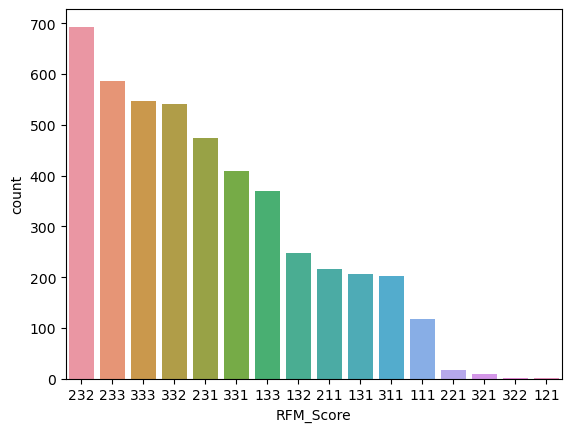

In [65]:
sns.countplot(rfm_table, x="RFM_Score", order = rfm_table['RFM_Score'].value_counts().index)

In [66]:
print(sorted(rfm_table['RFM_Score'].unique()))

['111', '121', '131', '132', '133', '211', '221', '231', '232', '233', '311', '321', '322', '331', '332', '333']


Укажем границы кластеров

In [67]:
rfm_percentile = rfm_table[['R_exam_submitted_avg_time', 'M_avg_score']].quantile([0, .333, .666, 1])
rfm_percentile

,R_exam_submitted_avg_time,M_avg_score
0.000,229.0,0.0
0.333,236.0,56.0
0.666,243.0,76.0
1.000,285.0,100.0


**Попробуем интерпритировать кластеры**

Посмотрим на тех, кто не завершил ни одного курса

In [68]:
rfm_table.query('F_success_score == 0'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
211,217,30.820276,241.235023
311,202,30.504950,231.547030
111,117,30.162393,244.623932


In [69]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)[['111', '211', '311']].sum().round(2)

11.57

1. **На пороге отчисления** - 11.57%

- 111
- 211
- 311

Можно предположить, что студенты в данных кластерах не удиляли много внимания учебе в течение семестра и в итоге не сдали ни одного экзамена.

============

Теперь рассмотрим тех, кто сдал хотя бы один курс

In [70]:
rfm_table.query('F_success_score == 0.5 & M_avg_score < 56'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
221,16,46.218750,240.000000
321,9,43.277778,232.555556
121,1,33.500000,243.500000


In [71]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)[['221', '321', '121']].sum().round(2)

0.58

2. **Потенциальные кандидаты на отчисление** - 0.58%

- 121
- 221
- 321

В отличие от первой группы, такие студенты сдали половину экзаменов. Однако остальная половина остается под вопросом, что также ставит под сомнение возможность их дальнейшего обучения.

============

Посмотрим на студентов, которые успешно завершили курс, но с невысоким проходным баллом (<56)

In [72]:
rfm_table.query('F_success_score == 1 & M_avg_score < 56'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
231,395,47.583544,240.988608
331,345,46.773913,231.549275
131,182,47.357143,244.571429


In [73]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)[['231', '331', '131']].sum().round(2)

23.46

3. **Отстающие студенты** - 23.46%

- 131
- 231
- 331

Такие студенты завершают курсы с невысоким проходным баллом. Возможно это студенты с низкой мотивацией или имеющие небольшие трудности с изучаемым материалом.

============

Теперь взглянем на студентов, которые успешно завершили курс, с более высоким проходным баллом (<76)

Сюда также можно отнести тех студентов, которые успешно завершили хотя бы один курс из двух с высоким проходным баллом

In [74]:
rfm_table.query('F_success_score == 1 & M_avg_score > 56 & M_avg_score < 76'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
232,629,65.440382,240.996025
332,495,66.021212,232.048485
132,226,66.048673,244.920354


In [75]:
rfm_table.query('F_success_score == 0.5 & M_avg_score > 56'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
322,1,58.0,230.0


In [76]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)[['232', '332', '132', '322']].sum().round(2)

31.99

4. **Хорошие студенты** - 31.99%

- 232
- 332
- 132
- 322

Вторая по доле группа студентов. Успешно и в небольшие сроки сдают все экзамены на высокую оценку и завершают курсы.

============

И в финале рассмотрим наиболее успешных студентов

In [77]:
rfm_table.query('F_success_score == 1 & M_avg_score > 76'). \
    groupby('RFM_Score').agg({'id_student':'count', 'M_avg_score':'mean', 'R_exam_submitted_avg_time':'mean'}).\
    sort_values('id_student', ascending=False)

,id_student,M_avg_score,R_exam_submitted_avg_time
RFM_Score,,,
233,586,86.691126,241.289249
333,546,88.271978,232.261905
133,369,90.844173,244.695122


In [78]:
rfm_table.RFM_Score.value_counts(normalize=True).mul(100)[['233', '333', '133']].sum().round(2)

32.4

5. **Отличники** - 32.4%

- 233
- 333
- 133

Группа самых успешных студентов с наибольшей долей.